# Imports/Setup

The work shown here attempts to use a Kalman filter to predict the prices of assets found in this portfolio. [portfolio](https://docs.google.com/spreadsheets/d/1EZj5M7dXGy-48i0PydZQa5gpUOYCQHDFRBlp_rU1sdo/edit#gid=1736594093)

[Helpful article...](https://medium.com/dataman-in-ai/kalman-filter-explained-4d65b47916bf)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from dateutil.relativedelta import relativedelta
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

stock_choice = 'MSFT'

# Collect Close Data

The cells below pulls in the relevant data for each of the assets in the portfolio, collecting a year's worth of close data.

In [2]:
investments = pd.read_csv('../Portfolio/investments.csv')
investments['weights'] = investments['initial_investment'] / investments['initial_investment'].sum()
investments.head()

,investment_type,GCIS_sector,name,country_of_origin,ticker,price_per_unit,initial_investment,number_of_units,weights
0,stocks,Energy,Exxon Mobil Corp,U.S.,XOM,116.70,400000,3427.592117,0.0500
1,stocks,Energy,PetroChina Co Ltd,China,PCCYF,0.66,400000,606060.606100,0.0500
2,stocks,Energy,NextEra Energy Inc.,U.S.,NEE,68.64,200000,2913.752914,0.0250
3,stocks,Materials,BHP Group Ltd,Austrailia,BHP,58.45,100000,1710.863986,0.0125
4,stocks,Materials,Air Products & Chemicals Inc,U.S.,APD,302.11,100000,331.005263,0.0125


In [3]:
close_data = pd.DataFrame(pd.date_range(dt.date(2022, 10, 30), periods=500).tolist())
close_data.columns = ['Date']

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    tmp = tmp.history(start=dt.date(2022, 10, 30), end=dt.date(2023, 10, 30))['Close'].reset_index()
    tmp['Date'] = pd.to_datetime(tmp['Date'].dt.date)
    tmp.columns = ['Date', ticker]

    close_data = pd.merge(close_data, tmp, how='inner', on='Date')
close_data.head()

,Date,XOM,PCCYF,NEE,BHP,APD,RTX,UNP,AMZN,TSLA,...,AMX,NG,IBDRY,PLD,PSA,BTC-USD,ETH-USD,GOVT,BNDX,LQD
0,2022-10-31,107.267914,0.350159,75.601204,46.512104,244.568161,92.532944,192.185120,102.440002,227.539993,...,18.577469,4.63,38.820980,107.678802,298.063416,20495.773438,1572.714478,21.865229,46.975559,97.401390
1,2022-11-01,108.332748,0.350159,75.806053,48.243416,246.248108,93.245338,191.873184,96.790001,227.820007,...,18.814501,4.79,38.773148,105.539810,296.033051,20485.273438,1579.704590,21.875004,46.999100,98.102180
2,2022-11-02,106.106277,0.368589,75.386589,46.755264,239.459961,91.879112,187.690979,92.120003,214.979996,...,18.765120,4.45,38.227856,103.779991,272.341949,20159.503906,1519.711792,21.845678,46.940235,97.629860
3,2022-11-03,107.548645,0.350159,76.264542,47.008156,257.870972,92.513435,188.334412,89.300003,215.309998,...,18.982399,4.40,37.634731,105.014786,266.231567,20209.988281,1531.541748,21.777266,46.793098,97.282814
4,2022-11-04,108.719963,0.368589,76.869347,51.589333,269.630554,92.923302,191.756195,90.980003,207.470001,...,19.683622,4.87,38.208725,104.635605,267.251556,21147.230469,1645.093384,21.728392,46.763657,97.475624


# Kalman Filter - Simple Example

The cells below create a simple Kalman filter that is used to estimate the closing prices of MFST.

In [4]:
from pykalman import KalmanFilter


kf_sample = close_data[['Date', stock_choice]]

# Construct a Kalman filter. Since our state vector only has a single value (price)
# we can use single values for all required matrices. The estimate and measurement
# error distributions are assumed to have mean 0 and standard deviation = 1.

kf = KalmanFilter(transition_matrices = [1],    # The value of transition matrix.
                  observation_matrices = [1],   # The value of the obersation matrix.
                  initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                  initial_state_covariance = 1, # Sigma value for the normally distributed estimate error.
                  observation_covariance=1,     # Sigma value for the normally distributed measurement error.
                  transition_covariance=.01)    # Allows for small turbulence in transition matrix.

# Get the Kalman estimates
state_means, _ = kf.filter(kf_sample[stock_choice].values)

# Add to dataframe
kf_sample['KF_estimate'] = np.array(state_means)
kf_sample.head()

,Date,MSFT,KF_estimate
0,2022-10-31,229.908905,114.954453
1,2022-11-01,225.986786,152.455439
2,2022-11-02,217.994003,169.365812
3,2022-11-03,212.199982,178.419670
4,2022-11-04,219.271667,185.823983


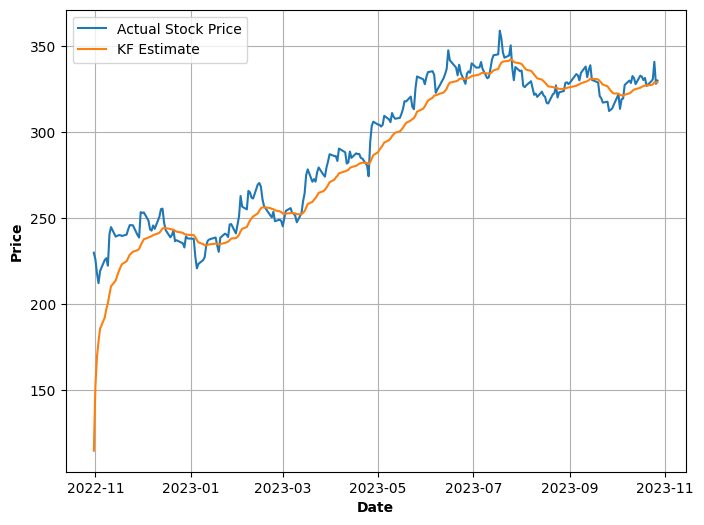

In [5]:
plt.figure(figsize=(8, 6))

plt.plot(kf_sample['Date'], kf_sample[stock_choice], label='Actual Stock Price')
plt.plot(kf_sample['Date'], kf_sample['KF_estimate'], label='KF Estimate')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Price', fontweight='bold')
#plt.title(f'{stock choice} KF Estimate', fontweight='bold')
plt.legend()
plt.grid()
plt.show()

As can be seen from the above plot, the Kalman very quickly adapts and does quite well in estimating MSFT's closing price. One of the primary differnces between the estimated and actual data is that the estimated data has a much smoother curve with less noise; this is one of the primary hallmarks of Kalman filter estimation. 

# Kalman Filter - Prediction Example

The cells below create an instance of `dart`'s `KalmanForecaster`, which uses a Kalman filter to make future predicitons on a set of data. This is done twice in the cells below (one instance in which data imputation is used, the other not) to see how well the forecaster predicts the last 4 days worth MFST's stock data.

In [6]:
kf_train = kf_sample[kf_sample['Date'] < dt.datetime(2023, 10, 24)]
actual = kf_sample[kf_sample['Date'] >= dt.datetime(2023, 10, 24)][stock_choice].values

In [7]:
# first try, filling in empty dates with mean stock price (required for the timeseries datatype
# when frequency is listed as "daily")

from darts.models import KalmanForecaster
from darts.utils.timeseries_generation import datetime_attribute_timeseries, constant_timeseries
from darts.timeseries import TimeSeries as ts

fill_val = kf_sample[stock_choice].mean()

kf_train = kf_train.set_index(['Date'])
kf_train = ts.from_dataframe(kf_train, value_cols=[stock_choice],
                             fillna_value=fill_val,freq='D',fill_missing_dates=True)
#kf_train = ts.from_dataframe(kf_sample, value_cols=['GOOGL'])
future_cov = datetime_attribute_timeseries(kf_train, 'day', add_length=4)

model = KalmanForecaster(dim_x=1)
model.fit(kf_train, future_covariates=future_cov)
pred = model.predict(4, future_covariates=future_cov)
preds = pred.values().reshape(-1)
preds

array([316.94050145, 317.1158472 , 317.28407247, 317.44516992])

In [8]:
# second try, using unlabelled time series so data imputation is not necessary.
# this is the better method

kf_train = kf_sample[kf_sample['Date'] < dt.datetime(2023, 10, 24)]
kf_train = ts.from_dataframe(kf_train, value_cols=[stock_choice])

future_cov = constant_timeseries(value=1, start=0, end=kf_sample.shape[0], length=None, freq=None)

model.fit(kf_train, future_covariates=future_cov)
pred = model.predict(4, future_covariates=future_cov)
preds = pred.values().reshape(-1)
preds

array([329.12619998, 329.22112789, 329.31534419, 329.40885421])

To check the success of the predictions, we can calculate their mean average percentage error (MAPE), which is a common statistic used to evaluate the performance of forecasting models.

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(actual, preds)

1.0854335326100002

We see from the above that for these four data points, the MAPE comes out to a little bit over 1%. For forecasting models, anything under 5% is considered to be highly accurate. 

# Kalman Filter - Analysis

The cell below creates a function to automate the process of running the Kalman forecaster on any of the portfolio assets for a user inputted number of predictions. Making predicitons over a larger timescale across multiple assets will give us a sense of the model's robustness. 

In [10]:
def run_kalman_forecaster(close, stock, num_predictions):
    
    if stock not in close.columns.values:
        return 'Ticker symbol not included in provided close dataset...'
    
    kf_sample = close[['Date', stock]]
    
    if num_predictions > close.shape[0]:
        return 'Number of expected predictions exceeds the number of observations...'
    
    num_samples = kf_sample.shape[0] - num_predictions
    kf_train = kf_sample.iloc[:num_samples]

    actual = kf_sample.iloc[num_samples:][stock].values
    dates = kf_sample.iloc[num_samples:]['Date'].values

    kf_train = ts.from_dataframe(kf_train, value_cols=[stock])

    future_cov = constant_timeseries(value=1, start=0, end=kf_sample.shape[0], length=None, freq=None)

    model.fit(kf_train, future_covariates=future_cov)
    pred = model.predict(num_predictions, future_covariates=future_cov)
    preds = pred.values().reshape(-1)
    mape = mean_absolute_percentage_error(actual, preds)
    return (dates, actual, preds, mape)

First, the cell below tests the function using the XOM stock price and makes predictions for the last 30 days:

In [11]:
test = run_kalman_forecaster(close_data, 'XOM', 30)
print(f'MAPE for Kalman Filter Forecaster using XOM stock over 30 days: {test[3]}')

MAPE for Kalman Filter Forecaster using XOM stock over 30 days: 2.2460258501780777


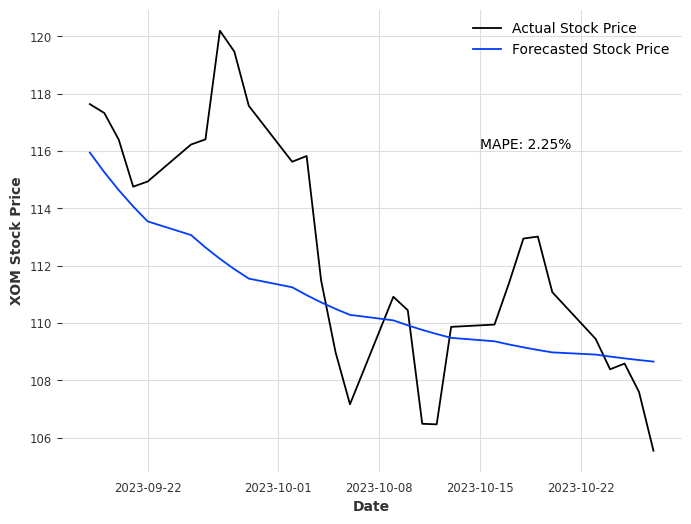

In [12]:
plt.figure(figsize=(8,6))

plt.plot(test[0], test[1], label='Actual Stock Price')
plt.plot(test[0], test[2], label='Forecasted Stock Price')
plt.text(dt.date(2023, 10, 15), 116.1, f'MAPE: {round(test[3], 2)}%')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('XOM Stock Price', fontweight='bold')
plt.legend()
plt.show()

We see from the above that the Kalman forecaster even performs quite well over a span of 30 days. The plot created below shows how the accuracy of the predictions decreases as the number of predicitons becomes larger:

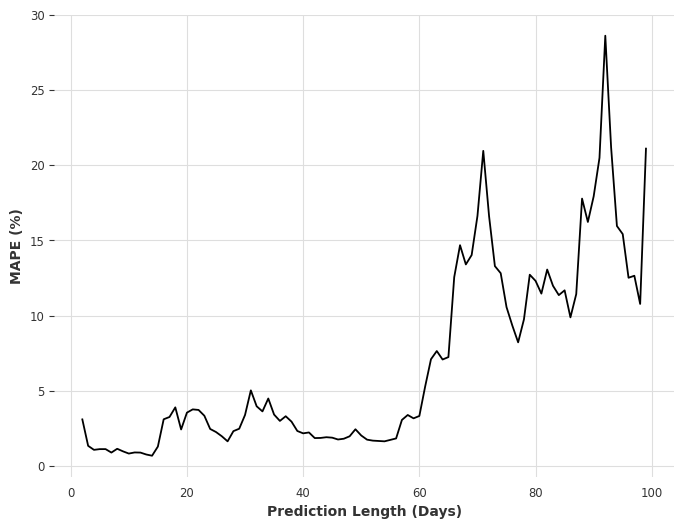

In [13]:
plt.figure(figsize=(8,6))
mapes = []

for i in range(2, 100):
    kf_run = run_kalman_forecaster(close_data, 'MSFT', i)
    mapes.append([i, kf_run[3]])
    
mapes = pd.DataFrame(mapes, columns=['Prediction Length', 'MAPE'])
plt.plot(mapes['Prediction Length'], mapes.MAPE)
plt.xlabel('Prediction Length (Days)', fontweight='bold')
plt.ylabel('MAPE (%)', fontweight='bold')
plt.show()

As in clear in the plot above, the MAPE tends to rise as we increase the number of days forecasted by the Kalman filter. As a final exercise, the plot created in the cells below show the MAPE values for all assets included in the portfolio when predicting their price for the past 30 days: 


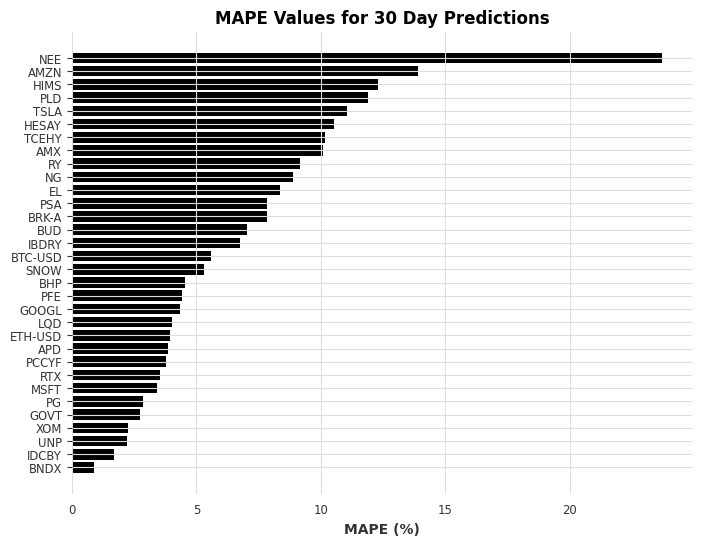

In [14]:
plt.figure(figsize=(8,6))
mapes = []

for ticker in investments.ticker.values:
    kf_run = run_kalman_forecaster(close_data, ticker, 30)
    mapes.append([ticker, kf_run[3]])

mapes = pd.DataFrame(mapes, columns=['ticker', 'mape'])
mapes = mapes.sort_values(by='mape')

plt.barh(mapes.ticker, mapes.mape)
plt.title('MAPE Values for 30 Day Predictions', fontweight='bold')
plt.xlabel('MAPE (%)')
plt.show()

While there are some higher MAPE values shown in the above plot, almost all of the assets exhibit MAPE values less than 10% (still considered to be quite accurate for forecasting models).

# Conclusion 

The results in the above prove that the Kalman Filter does remarkably well when making predictions on closing stock prices, espeically on short timescales. 